In [29]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from proj_acquire import *
from proj_prepare import *

import zgulde.extend_pandas as ep

In [2]:
df = prepare_fitbit()

In [4]:
# set date to index
df.set_index('index', inplace=True)

# dropping columns with mostly zero information
to_drop = ['calories', 'carbs', 'fat', 'fiber',
       'protien', 'sodium', 'water']
df = df.drop(columns=(to_drop))

# remove commas and convert to float64
for col in df:
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].astype('float64')

# drop NaN rows as we'll be predicting them anyway
df.dropna(inplace=True)

In [105]:
df.drop(columns='level_0', inplace=True)
df

,activity_calories,distance,floors,mins_active_high,mins_active_light,mins_active_med,mins_sedentary,steps,total_calories
index,,,,,,,,,
2018-04-26,566.0,1.38,2.0,0.0,93.0,0.0,1347.0,2931.0,2635.0
2018-04-27,1752.0,4.70,19.0,17.0,219.0,46.0,1158.0,9971.0,3649.0
2018-04-28,1124.0,1.66,2.0,11.0,155.0,22.0,702.0,3521.0,3379.0
2018-04-29,602.0,0.77,0.0,0.0,122.0,0.0,891.0,1639.0,2851.0
2018-04-30,540.0,0.62,0.0,0.0,104.0,0.0,880.0,1323.0,2825.0
2018-05-01,1068.0,1.22,0.0,2.0,167.0,13.0,919.0,2581.0,3292.0
2018-05-02,419.0,0.65,0.0,0.0,90.0,0.0,927.0,1372.0,2660.0
2018-05-03,1006.0,1.05,0.0,0.0,157.0,16.0,876.0,2232.0,3121.0
2018-05-04,269.0,0.43,1.0,0.0,61.0,0.0,1012.0,904.0,2522.0


In [108]:
for col in df:
    print(f'{col}: {df[col].outliers().sum()})

3
1
12
0
17
11
22
1
4


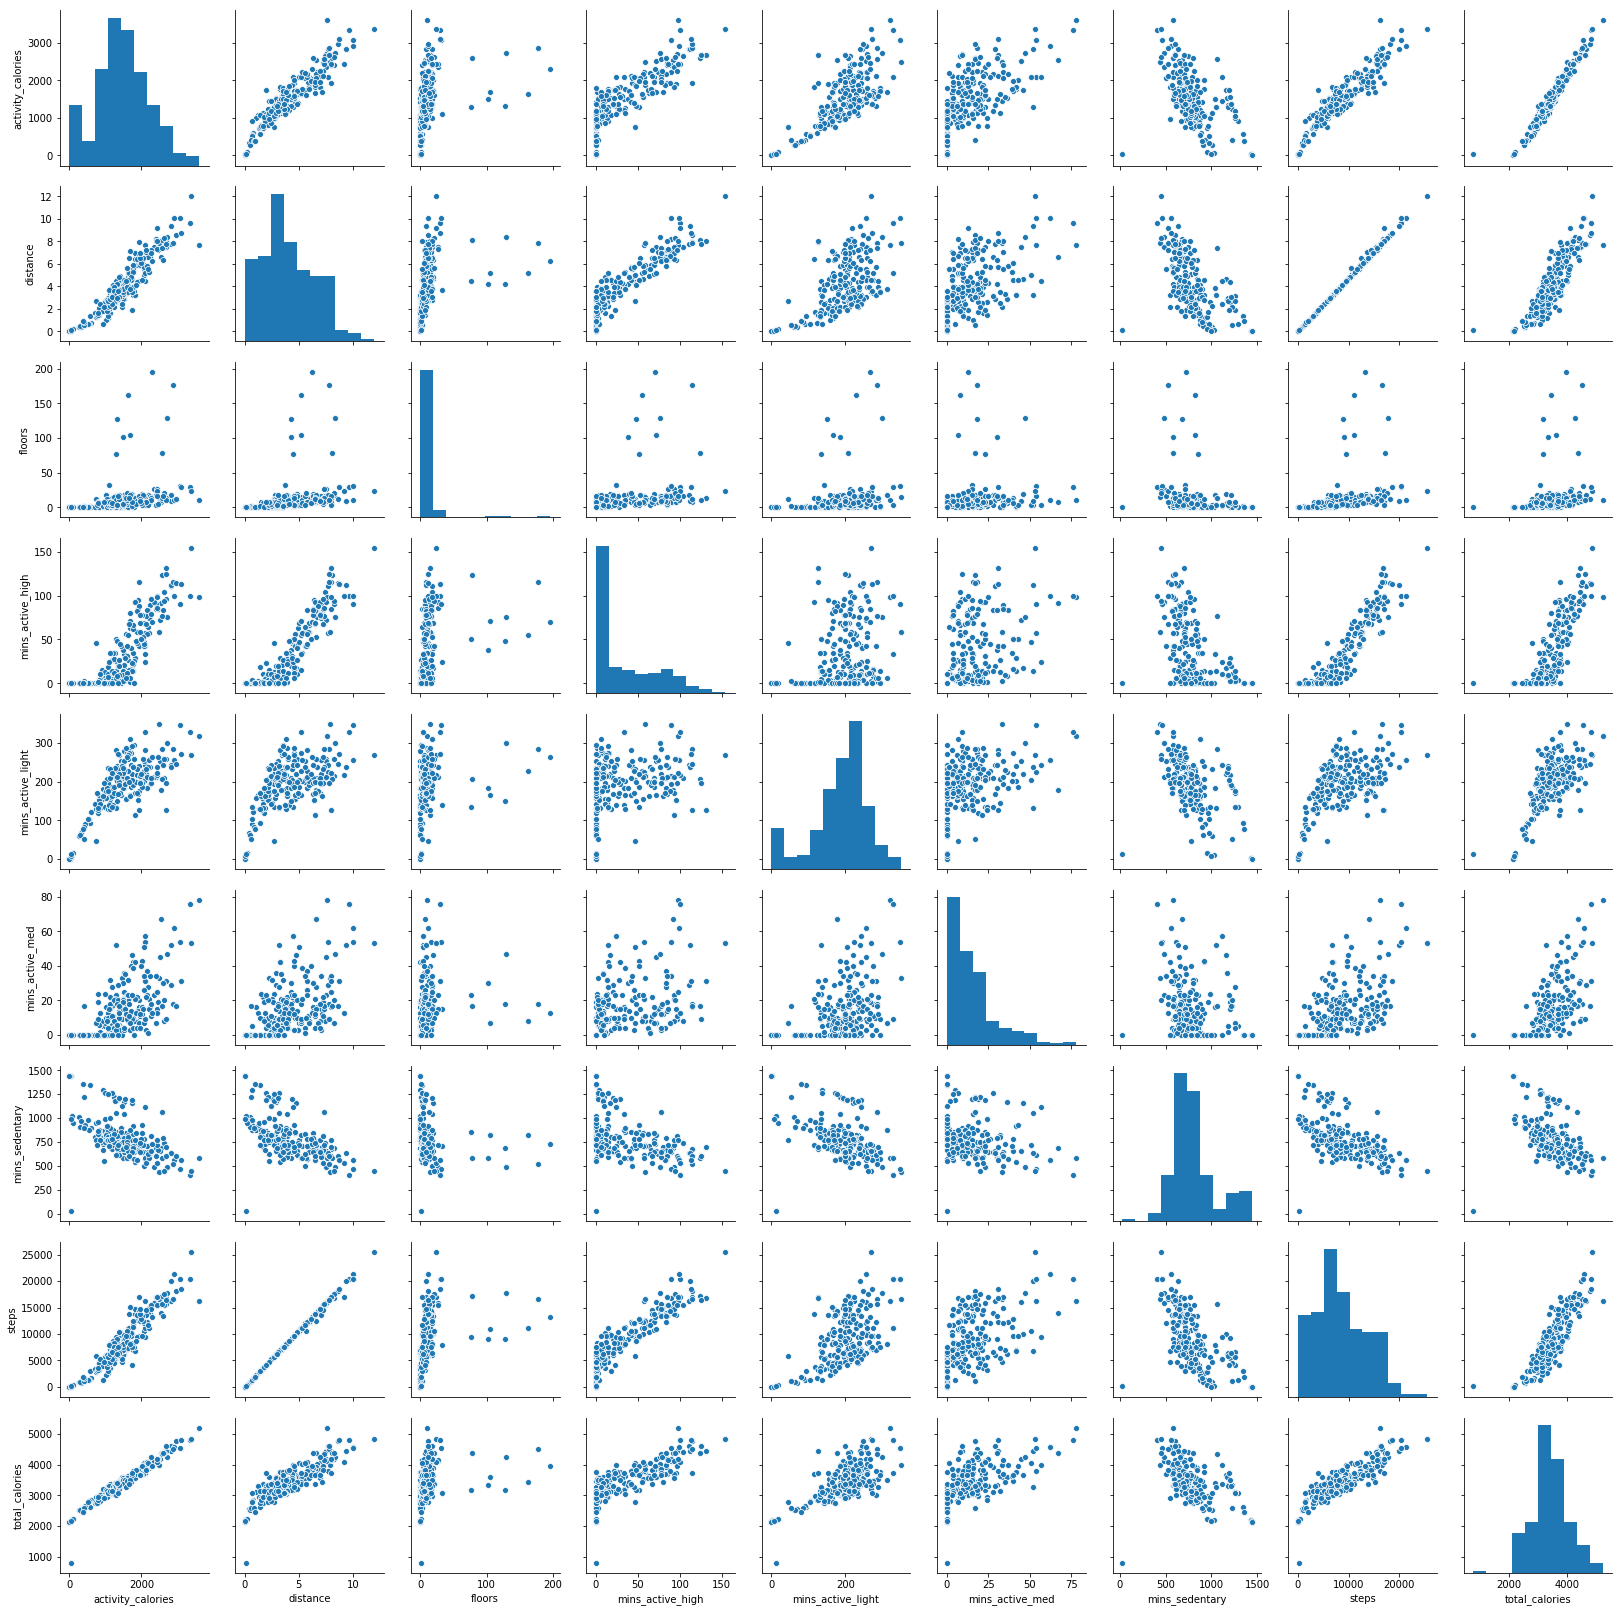

In [106]:
sns.pairplot(df)

In [5]:
def peekatdata(df):
    '''gives cursory sample of dataframe passed'''
    head_df = df.head(5)
    print(head_df)
    tail_df = df.tail(5)
    print(tail_df)
    shape_tuple = df.shape
    print(shape_tuple)
    describe_df = df.describe()
    print(describe_df)
    df.info()

In [10]:
train = df['2018-04':'2018-09']
test = df['2018-10':'2018-12']
print(train.nunique())
print(test.nunique())

activity_calories    145
distance             130
floors                25
mins_active_high      60
mins_active_light    108
mins_active_med       46
mins_sedentary       131
steps                146
total_calories       145
dtype: int64
activity_calories    65
distance             63
floors               31
mins_active_high     50
mins_active_light    53
mins_active_med      32
mins_sedentary       61
steps                67
total_calories       67
dtype: int64


# Exploration

### mean total calories by day

Text(0.5, 0, 'day')

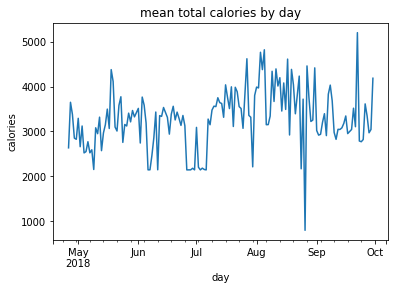

In [22]:
t_cal = train.resample('D').total_calories.mean()
t_cal.plot()
plt.title('mean total calories by day')
plt.ylabel('calories')
plt.xlabel('day')

### mean total calories by week

Text(0.5, 0, 'weeks')

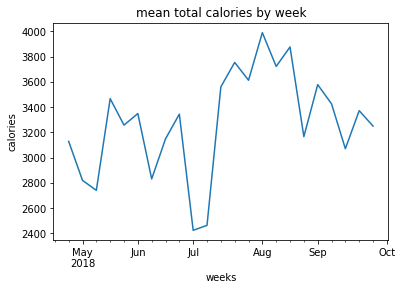

In [21]:
t_cal.resample('W').mean().plot()
plt.title('mean total calories by week')
plt.ylabel('calories')
plt.xlabel('weeks')

### mean total calories by month

Text(0.5, 0, 'month')

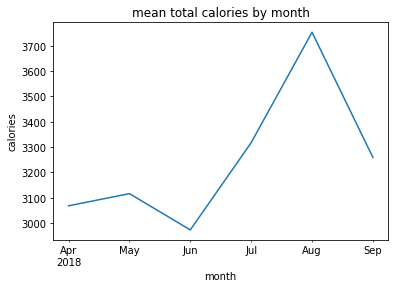

In [20]:
t_cal.resample('MS').mean().plot()
plt.title('mean total calories by month')
plt.ylabel('calories')
plt.xlabel('month')

### 5 period rolling mean and plot

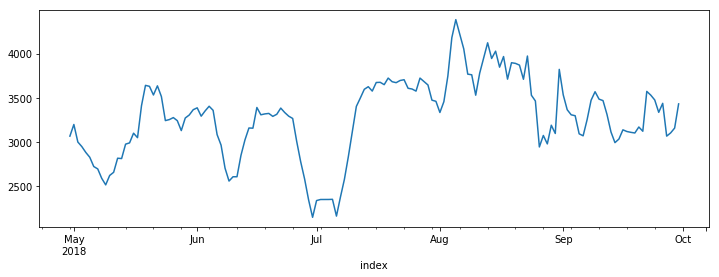

In [23]:
t_cal.rolling(5).mean().plot(figsize=(12, 4))

### 10 period rolling mean and plot

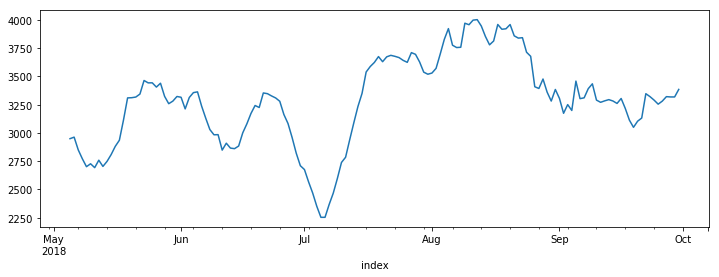

In [24]:
t_cal.rolling(10).mean().plot(figsize=(12, 4))

### Time-series decomposition - trend, seasonality, and noise

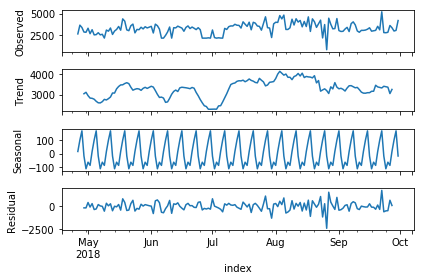

In [26]:
decomposition = sm.tsa.seasonal_decompose(t_cal, model='additive')
fig = decomposition.plot()
plt.show()

### lag plot

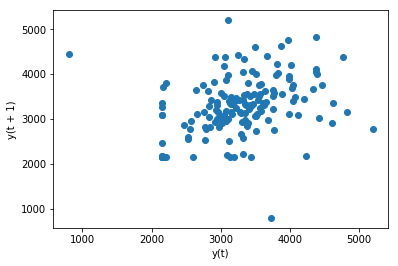

In [27]:
pd.plotting.lag_plot(t_cal)

### pearson's correlation coef

In [28]:
df_corr = pd.concat([t_cal.shift(1), t_cal], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.317357
t+1  0.317357  1.000000


# Modeling

In [41]:
agg1 = 'mean'
agg2 = 'sum'

In [47]:
ts_data1 = df.total_calories.resample('W').agg(agg1)
ts_data2 = df.total_calories.resample('W').agg(agg2)

In [48]:
train_size1 = int(len(ts_data1) * 0.66)
train_1, test_1 = ts_data1[0:train_size1], ts_data1[train_size1:len(ts_data1)]
print('Observations: %d' % (len(ts_data1)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

train_size2 = int(len(ts_data2) * 0.66)
train_2, test_2 = ts_data2[0:train_size2], ts_data2[train_size2:len(ts_data2)]
print('Observations: %d ' % (len(ts_data2)))
print('Training Observations: %d' % (len(train_2)))
print('Testing Observations: %d' % (len(test_2)))

Observations: 33
Training Observations: 21
Testing Observations: 12
Observations: 33 
Training Observations: 21
Testing Observations: 12


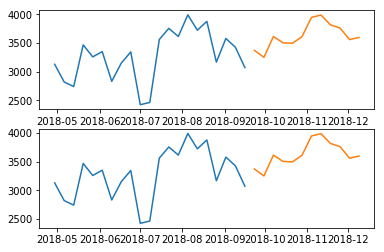

In [50]:
plt.subplot(211)
plt.plot(train_1)
plt.plot(test_1)

plt.subplot(212)
plt.plot(train_1)
plt.plot(test_1)

plt.show()

### Simple Average

In [65]:
df.set_index('index', inplace=True)

In [67]:
train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 158
Testing Observations: 67


In [98]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat.head()

,actual,avg_forecast
index,,
2018-10-01,3180.0,3278.968354
2018-10-02,3162.0,3278.968354
2018-10-03,3584.0,3278.968354
2018-10-04,3713.0,3278.968354
2018-10-05,3603.0,3278.968354


In [99]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

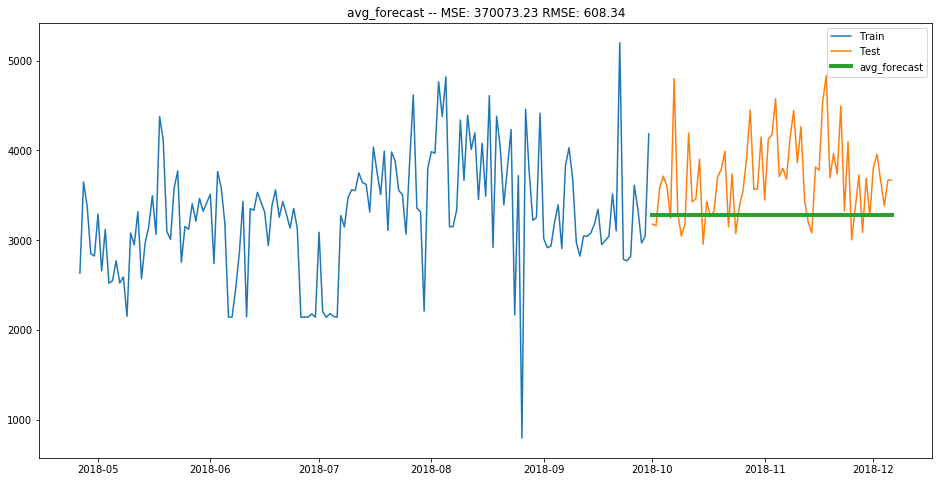

In [100]:
plot_and_eval(yhat.avg_forecast)

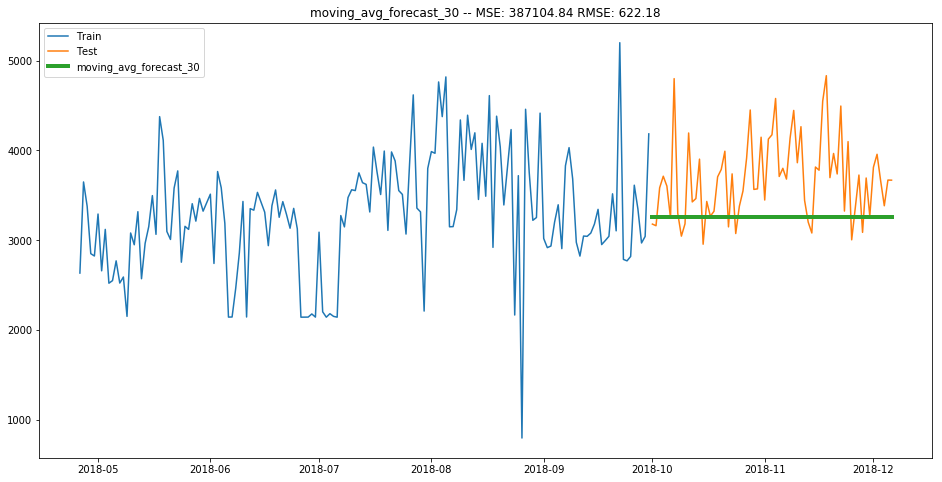

In [101]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_30)

In [102]:
yhat

,actual,avg_forecast,moving_avg_forecast_30
index,,,
2018-10-01,3180.0,3278.968354,3258.833333
2018-10-02,3162.0,3278.968354,3258.833333
2018-10-03,3584.0,3278.968354,3258.833333
2018-10-04,3713.0,3278.968354,3258.833333
2018-10-05,3603.0,3278.968354,3258.833333
2018-10-06,3246.0,3278.968354,3258.833333
2018-10-07,4799.0,3278.968354,3258.833333
2018-10-08,3299.0,3278.968354,3258.833333
2018-10-09,3046.0,3278.968354,3258.833333


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

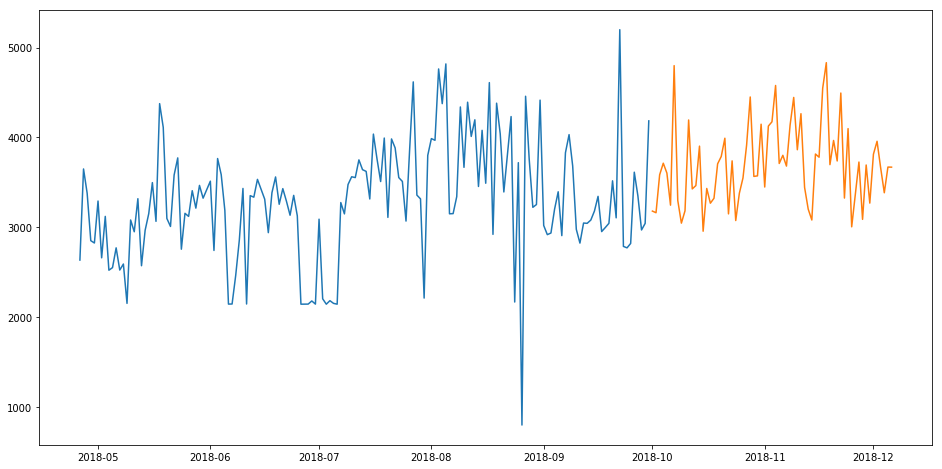

In [97]:
period_vals = [1, 4, 12, 26]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean()

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, linewidth=2)

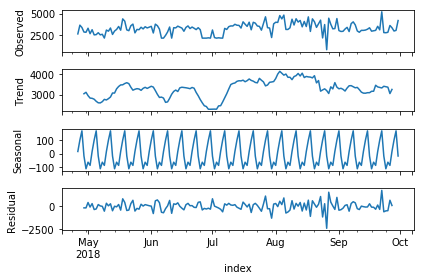

In [74]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

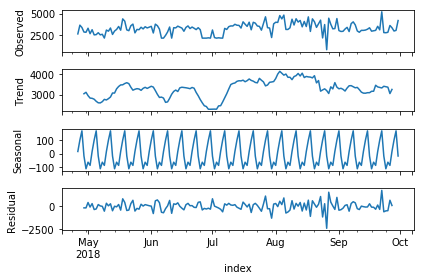

In [75]:
# train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
# test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

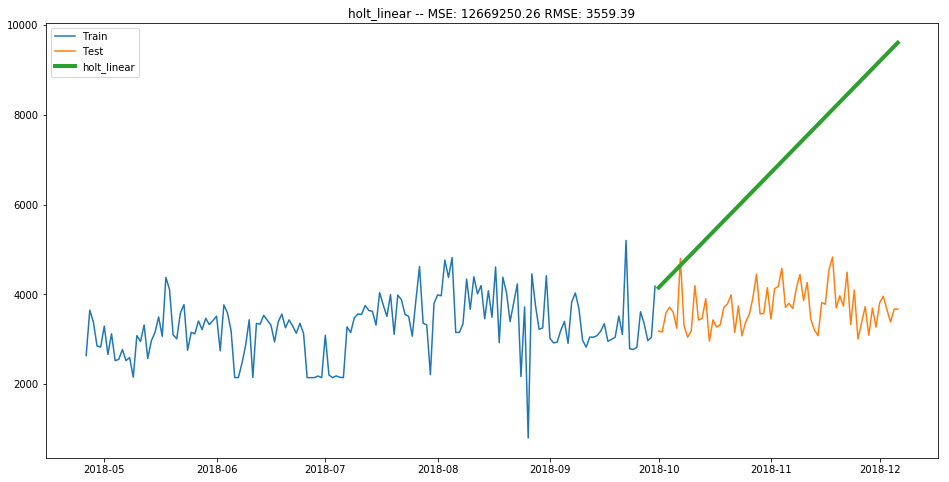

In [88]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.9, smoothing_slope=.1)

yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

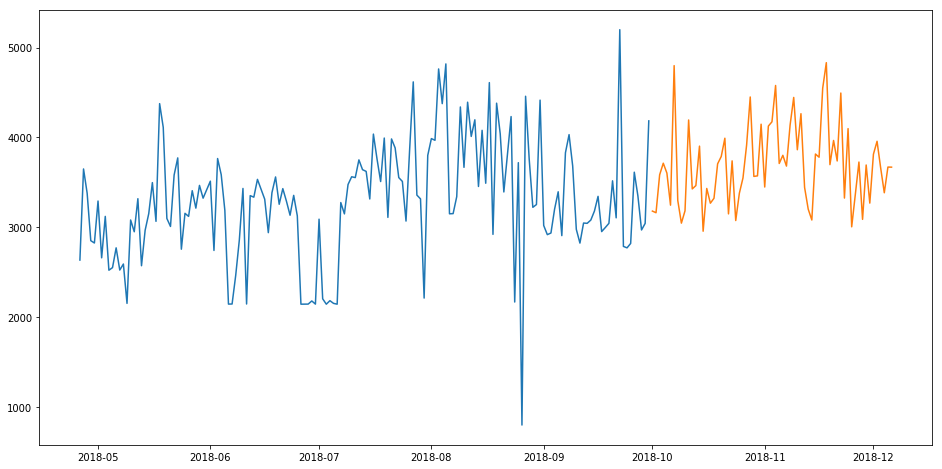

In [79]:
using_last_year = train['2018-04']\
    .reset_index()\
    .drop(columns='index')\
    .set_index(train['2018-04'].index + 90)\

yhat['next_90'] = using_last_year
plot_and_eval(yhat.next_90, linewidth=1)

# Prophet

In [82]:
df.columns

Index(['level_0', 'activity_calories', 'distance', 'floors',
       'mins_active_high', 'mins_active_light', 'mins_active_med',
       'mins_sedentary', 'steps', 'total_calories'],
      dtype='object')

In [81]:
import seaborn as sns
from fbprophet import Prophet

In [ ]:
d_df = df[df['total_calories']>50]
d_df = d_df[d_df['activity_calories']>50]

d_df['y'] = d_df.sale_amount * d_df.item_price
d_df['ds'] = pd.to_datetime(d_df.sale_date)
d_df = d_df.groupby(['ds'])['y'].sum().reset_index()